# Sentiment Analysis of daily NEWS
### Description:
This project attempts to analyze the daily news we are subjected to. The complete analysis consists of 2 Sections.

<b>Section 1:</b> This section involves sentiment analysis of the news articles, We try and investigate the sentiments associated with the news articles to answer the following questions

1. Is the Media focussing too much on the negative side of the story? Do the negative news dominate the headlines ?
2. Is there a perticular trend in the way the major publishishers from around the world report stories?
3. Do the word distribution in news articles picked up randomly follow the zipf's law?
4. Bigram Analysis of the headlines

<b>Section 2:</b> Impact of News sentiment on stock market prices. Does it mean that if news is demoninated with negative news, the stock prices fall?

<b>Note: </b>While rerunning the data collection part, kindly ensure that the start date of the API call is no later than one month prior to the current date in order to avoid any errors

In [110]:
# import necessary libraries
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import matplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from rake_nltk import Rake 

## Task 1: Identify a suitable web API
<b>API Chosen:</b> Two API's were chosen for this project, all the news articles were collected from https://newsapi.org/ . NewsAPI provides real time news articles from a wide variety of news publishers. The data for the stock prices was needed in the Section 2 of this project and hence another API was needed. The data was obtained from https://www.worldtradingdata.com/

In [85]:
url = 'https://newsapi.org/v2/everything?'

In [86]:
api_key = 'c67881b14d9c453b9693ac4c1d93ac05' 

The following two functions are used to gather the data from the api and put it in a dataframe. The get_article function takes the raw data in the form of a dictionary and combines it in a structured format

In [87]:
# function to take raw data from the API and process it into a list inorder to trnasform it into a pandas dataframe
def get_articles(file): 
    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['author'] = file[i]['author']
        article_dict['content'] = file[i]['content']  
        article_dict['description'] = file[i]['description']
        article_dict['photo_url'] = file[i]['urlToImage']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['source'] = file[i]['source']
        article_dict['title'] = file[i]['title']
        article_dict['url'] = file[i]["url"]
        
        article_results.append(article_dict)
    return article_results

## Task 2: Collect data you have chosen API(s)
The data for this assignment was collected in two stages because the API has a restrictions. The API only returned 100 news articles in an API call and the news could only be collected upto 1 month prior to the current date. In order to collect sufficent data for analysis, I used to approaches:

1. Collect 100 articles per New Publish so that I could iterate through a list of News publishers and collect 100 news articles from each one of them

2. Collect data in two phases. In phase 1 of the collection i collected data from 14th February till 14th March and in phase 2 I collected data from 15th March onwards till 29th of March 2020.

In [88]:
# Collecting the first 100 articles about ireland to check the API and the working of the function 
parameters_headlines = {
    'q': 'Ireland',
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'start' : '2020-04-15'    
}
# making the API call 
response_headline = requests.get(url, params = parameters_headlines)
response_json_headline = response_headline.json()
responses = response_json_headline["articles"]
# transforminf the data from JSON dictionary to a pandas data frame
news_articles_df = pd.DataFrame(get_articles(responses))
# printing the head to check the format and the working of the get_articles function
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url
0,Mitchell Clark,People in plenty of countries may have to pay ...,Apple bragged about not raising the starting p...,https://cdn.vox-cdn.com/thumbor/WFqEevecKF_mXP...,2022-09-09T00:09:44Z,"{'id': 'the-verge', 'name': 'The Verge'}",Apple did raise prices with the iPhone 14 and ...,https://www.theverge.com/2022/9/8/23343550/app...
1,Cheryl Eddy,New Disney+ series Andor is grabbing all the S...,New Disney+ series Andor is grabbing all the S...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-27T16:50:00Z,"{'id': None, 'name': 'Gizmodo.com'}",Jedi Meet a Force Cult in the Latest Star Wars...,https://gizmodo.com/star-wars-novel-high-repub...
2,Ed Cara,A dogs snoot may be well-suited to sniffing ou...,A dog’s snoot may be well-suited to sniffing o...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-28T21:03:00Z,"{'id': None, 'name': 'Gizmodo.com'}",Stressed? Your Dog Can Probably Smell It,https://gizmodo.com/dogs-can-smell-stress-1849...
3,None,Bundee Aki (right) was sent off for a dangerou...,Bundee Aki is set to miss Ireland's autumn int...,https://ichef.bbci.co.uk/live-experience/cps/6...,2022-09-29T15:04:30Z,"{'id': 'bbc-news', 'name': 'BBC News'}",Bundee Aki: Ireland and Connacht centre banned...,https://www.bbc.co.uk/sport/rugby-union/63080213
4,https://www.facebook.com/bbcnews,"By Gary O'DonoghueWashington correspondent, BB...",Expect unity on Ukraine and China but there's ...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10T23:24:16Z,"{'id': 'bbc-news', 'name': 'BBC News'}",Liz Truss and Joe Biden: The big issue that co...,https://www.bbc.co.uk/news/world-us-canada-628...


As we can see from the above result that the data is correctly being transformed from a dictionary to a pandas dataframe and hence we can go ahead and loop through the list of reputated sources and make an API call to fetch 100 news articles from that source. I appended the results of each API call to the dataframe. This alowed me to collect collect sufficient data from the API

In [89]:
import warnings
warnings.filterwarnings("ignore")

In [90]:
responses = list() # stores responses for various news sources
domains = ['wsj.com','aljazeera.com','bbc.co.uk','techcrunch.com', 'nytimes.com','bloomberg.com','businessinsider.com',
             'cbc.ca','cnbc.com','cnn.com','ew.com','espn.go.com','espncricinfo.com','foxnews.com', 'apnews.com',
             'news.nationalgeographic.com','nymag.com','reuters.com','rte.ie','thehindu.com','huffingtonpost.com',
             'irishtimes.com','timesofindia.indiatimes.com','washingtonpost.com','time.com','medicalnewstoday.com',
             'ndtv.com','theguardian.com','dailymail.co.uk','firstpost.com','thejournal.ie', 'hindustantimes.com',
             'economist.com','news.vice.com','usatoday.com','telegraph.co.uk','metro.co.uk','mirror.co.uk','news.google.com']
for domain in domains:
    parameters_headlines = {
    'domains':format(domain),
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'start' : '2020-04-15'    
    }
    rr = requests.get(url, params = parameters_headlines)
    data = rr.json()
    responses = data["articles"]
    news_articles_df=news_articles_df.append(pd.DataFrame(get_articles(responses)))

KeyError: 'articles'

In [ ]:
print(news_articles_df.shape)
news_articles_df.head()

## Task 3: Cleaning and preprocessing the Data

In [91]:
# function to exatract just the name of the source of the news article and exclude other details
def source_getter(df):
    source = []
    for source_dict in df['source']:
        source.append(source_dict['name'])
    df['source'] = source #append the source to the df

In [92]:
# this fuincton extracts the source name from the source dictionary as seen above
source_getter(news_articles_df)

In [93]:
# converted the publication date to date time format for future analysis
news_articles_df['pub_date'] = pd.to_datetime(news_articles_df['pub_date']).apply(lambda x: x.date())

In [94]:
#look for missing data
news_articles_df.isnull().sum() 

author         104
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
dtype: int64

We can see that there are quite a few missing values present in the dataset and since the dataset is purely textual in nature and given the type of fields having the missing value, it is not possible to fill the missing values in this case hence I dicided to drop all rows with null values.

In [95]:
# droping the rows with missing data 
news_articles_df.dropna(inplace=True)
news_articles_df = news_articles_df[~news_articles_df['description'].isnull()]
# summarize the number of rows and columns in the dataset
print(news_articles_df.isnull().sum())
print(news_articles_df.shape)

author         0
content        0
description    0
photo_url      0
pub_date       0
source         0
title          0
url            0
dtype: int64
(296, 8)


The title along with the content provided significant detail regarding the story and both columns contained soem keywords which were essential for futher analysis hence they were combined to form one column

In [96]:
# combine the title and the content to get one dataframe column
news_articles_df['combined_text'] = news_articles_df['title'].map(str) +" "+ news_articles_df['content'].map(str) 

In [97]:
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url,combined_text
0,Mitchell Clark,People in plenty of countries may have to pay ...,Apple bragged about not raising the starting p...,https://cdn.vox-cdn.com/thumbor/WFqEevecKF_mXP...,2022-09-09,The Verge,Apple did raise prices with the iPhone 14 and ...,https://www.theverge.com/2022/9/8/23343550/app...,Apple did raise prices with the iPhone 14 and ...
1,Cheryl Eddy,New Disney+ series Andor is grabbing all the S...,New Disney+ series Andor is grabbing all the S...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-27,Gizmodo.com,Jedi Meet a Force Cult in the Latest Star Wars...,https://gizmodo.com/star-wars-novel-high-repub...,Jedi Meet a Force Cult in the Latest Star Wars...
2,Ed Cara,A dogs snoot may be well-suited to sniffing ou...,A dog’s snoot may be well-suited to sniffing o...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-28,Gizmodo.com,Stressed? Your Dog Can Probably Smell It,https://gizmodo.com/dogs-can-smell-stress-1849...,Stressed? Your Dog Can Probably Smell It A dog...
4,https://www.facebook.com/bbcnews,"By Gary O'DonoghueWashington correspondent, BB...",Expect unity on Ukraine and China but there's ...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Liz Truss and Joe Biden: The big issue that co...,https://www.bbc.co.uk/news/world-us-canada-628...,Liz Truss and Joe Biden: The big issue that co...
5,https://www.facebook.com/bbcnews,The Queen will lie in state for four days befo...,People will be able to view the Queen's coffin...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Queen to lie in state for four full days befor...,https://www.bbc.co.uk/news/uk-62863486,Queen to lie in state for four full days befor...


Applying Text Preprocessing steps: In the followting sections, some of the text preprocessing steps were applied to the data. The steps included:

- Tokenization
- Removing the non ASCII characters from the text
- Stop words removal
- Removing punctuations, apostrophe, special characters etc
- lemmatize the text

In [98]:
# Function to remove non-ascii characters from the text
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)
# function to remove the punctuations, apostrophe, special characters using regular expressions
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text
# stop words are the words that convery little to no information about the actual content like the words:the, of, for etc
def remove_stopwords(word_tokens):
    filtered_sentence = [] 
    stop_words = stopwords.words('english')
    specific_words_list = ['char', 'u', 'hindustan', 'doj', 'washington'] 
    stop_words.extend(specific_words_list )
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    return filtered_sentence
# function for lemmatization 
def lemmatize(x):
    lemmatizer = WordNetLemmatizer()
    return' '.join([lemmatizer.lemmatize(word) for word in x])

In [99]:
# splitting a string, text into a list of tokens
tokenizer = RegexpTokenizer(r'\w+')
def tokenize(x): 
    return tokenizer.tokenize(x)

In [100]:
# applying all of these functions to the our dataframe 
news_articles_df['combined_text'] = news_articles_df['combined_text'].map(clean_text)
news_articles_df['tokens'] = news_articles_df['combined_text'].map(tokenize)
news_articles_df['tokens'] = news_articles_df['tokens'].map(remove_stopwords)
news_articles_df['lems'] =news_articles_df['tokens'].map(lemmatize)

In [101]:
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url,combined_text,tokens,lems
0,Mitchell Clark,People in plenty of countries may have to pay ...,Apple bragged about not raising the starting p...,https://cdn.vox-cdn.com/thumbor/WFqEevecKF_mXP...,2022-09-09,The Verge,Apple did raise prices with the iPhone 14 and ...,https://www.theverge.com/2022/9/8/23343550/app...,apple did raise prices with the iphone and wa...,"[apple, raise, prices, iphone, watch, series, ...",apple raise price iphone watch series u china ...
1,Cheryl Eddy,New Disney+ series Andor is grabbing all the S...,New Disney+ series Andor is grabbing all the S...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-27,Gizmodo.com,Jedi Meet a Force Cult in the Latest Star Wars...,https://gizmodo.com/star-wars-novel-high-repub...,jedi meet a force cult in the latest star wars...,"[jedi, meet, force, cult, latest, star, wars, ...",jedi meet force cult latest star war high repu...
2,Ed Cara,A dogs snoot may be well-suited to sniffing ou...,A dog’s snoot may be well-suited to sniffing o...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-28,Gizmodo.com,Stressed? Your Dog Can Probably Smell It,https://gizmodo.com/dogs-can-smell-stress-1849...,stressed your dog can probably smell it a dogs...,"[stressed, dog, probably, smell, dogs, snoot, ...",stressed dog probably smell dog snoot may well...
4,https://www.facebook.com/bbcnews,"By Gary O'DonoghueWashington correspondent, BB...",Expect unity on Ukraine and China but there's ...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Liz Truss and Joe Biden: The big issue that co...,https://www.bbc.co.uk/news/world-us-canada-628...,liz truss and joe biden the big issue that cou...,"[liz, truss, joe, biden, big, issue, could, de...",liz truss joe biden big issue could derail uk ...
5,https://www.facebook.com/bbcnews,The Queen will lie in state for four days befo...,People will be able to view the Queen's coffin...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Queen to lie in state for four full days befor...,https://www.bbc.co.uk/news/uk-62863486,queen to lie in state for four full days befor...,"[queen, lie, state, four, full, days, state, f...",queen lie state four full day state funeral qu...


In [102]:
# finding the keywords using the rake algorithm from NLTK
# rake is Rapid Automatic Keyword Extraction algorithm, and is used for domain independent keyword extraction
news_articles_df['keywords'] = ""
for index,row in news_articles_df.iterrows():
    comb_text = row['combined_text']
    r = Rake()
    r.extract_keywords_from_text(comb_text)
    key_words_dict = r.get_word_degrees()
    row['keywords'] = list(key_words_dict.keys())

In [68]:
# applying the fucntion to the dataframe
news_articles_df['keywords'] = news_articles_df['keywords'].map(remove_stopwords)
news_articles_df['lems'] =news_articles_df['keywords'].map(lemmatize)

In [103]:
news_articles_df.head()
news_articles_df.to_csv(r'C:\Users\user\Datasets\news\news_articles2_clean.csv', index = False)

In [104]:
news_articles_df.head()

,author,content,description,photo_url,pub_date,source,title,url,combined_text,tokens,lems,keywords
0,Mitchell Clark,People in plenty of countries may have to pay ...,Apple bragged about not raising the starting p...,https://cdn.vox-cdn.com/thumbor/WFqEevecKF_mXP...,2022-09-09,The Verge,Apple did raise prices with the iPhone 14 and ...,https://www.theverge.com/2022/9/8/23343550/app...,apple did raise prices with the iphone and wa...,"[apple, raise, prices, iphone, watch, series, ...",apple raise price iphone watch series u china ...,"[apple, raise, prices, iphone, watch, series, ..."
1,Cheryl Eddy,New Disney+ series Andor is grabbing all the S...,New Disney+ series Andor is grabbing all the S...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-27,Gizmodo.com,Jedi Meet a Force Cult in the Latest Star Wars...,https://gizmodo.com/star-wars-novel-high-repub...,jedi meet a force cult in the latest star wars...,"[jedi, meet, force, cult, latest, star, wars, ...",jedi meet force cult latest star war high repu...,"[jedi, meet, force, cult, latest, star, wars, ..."
2,Ed Cara,A dogs snoot may be well-suited to sniffing ou...,A dog’s snoot may be well-suited to sniffing o...,https://i.kinja-img.com/gawker-media/image/upl...,2022-09-28,Gizmodo.com,Stressed? Your Dog Can Probably Smell It,https://gizmodo.com/dogs-can-smell-stress-1849...,stressed your dog can probably smell it a dogs...,"[stressed, dog, probably, smell, dogs, snoot, ...",stressed dog probably smell dog snoot may well...,"[stressed, dog, probably, smell, dogs, snoot, ..."
4,https://www.facebook.com/bbcnews,"By Gary O'DonoghueWashington correspondent, BB...",Expect unity on Ukraine and China but there's ...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Liz Truss and Joe Biden: The big issue that co...,https://www.bbc.co.uk/news/world-us-canada-628...,liz truss and joe biden the big issue that cou...,"[liz, truss, joe, biden, big, issue, could, de...",liz truss joe biden big issue could derail uk ...,"[liz, truss, joe, biden, big, issue, could, de..."
5,https://www.facebook.com/bbcnews,The Queen will lie in state for four days befo...,People will be able to view the Queen's coffin...,https://ichef.bbci.co.uk/news/1024/branded_new...,2022-09-10,BBC News,Queen to lie in state for four full days befor...,https://www.bbc.co.uk/news/uk-62863486,queen to lie in state for four full days befor...,"[queen, lie, state, four, full, days, state, f...",queen lie state four full day state funeral qu...,"[queen, lie, state, four, full, days, funeral,..."


<b>Note:</b> This completes one phase of data collecton step. Exact same process was followed with just the change in date in order to get the news articles of a date beyond 1 month. Including the same proceduce twice would have made it redundant hence I have directly included the two CSV files directly.

## Combining the data collected in two phases

In [105]:
#Combining the collected data
dataframe1=pd.read_csv(r'C:\Users\user\Datasets\news\news_articles2_clean.csv')
# dataframe1 contains the articles from 14th Feb to 14 March 
dataframe2=pd.read_csv(r'C:\Users\user\Datasets\news\news_articles2_clean.csv')
# dataframe2 contains the articles from 14 March to 29th March 
dataframe_combined_data = pd.concat([dataframe1, dataframe2], ignore_index=True)

In [106]:
dataframe_combined_data.to_csv(r'C:\Users\user\Datasets\news\news_combined.csv', index = False)

In [107]:
# reading the new combined data in the news_articles dataframe
news_articles_df = pd.read_csv(r'C:\Users\user\Datasets\news\news_combined.csv')

In [108]:
# Checking the combined data once again to ensure no null value is present
print(news_articles_df.isnull().sum())
news_articles_df.dropna(inplace=True)
print(news_articles_df.shape)
print(news_articles_df.isnull().sum())

author           0
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
combined_text    0
tokens           0
lems             0
keywords         0
dtype: int64
(592, 12)
author           0
content          0
description      0
photo_url        0
pub_date         0
source           0
title            0
url              0
combined_text    0
tokens           0
lems             0
keywords         0
dtype: int64


## Task 4: Sentiment Analysis of News articles to answer our Questions

In [111]:
# calculating the polarity of the news articles 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
results = []
for line in news_articles_df['lems'] :
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


In [112]:
# Creating a new dataframe of only the polarity score, the headline and the source of the news 
headlines_polarity = pd.DataFrame.from_records(results)
temp = []
for line in news_articles_df['source'] :
    temp.append(line)
headlines_polarity['source'] =temp

In [113]:
# categorize news as positive or negative based on the compound score obtained
headlines_polarity['label'] = 0
# I have considered the news as positive if the compound score is greater than 0.2 hence the label 1
headlines_polarity.loc[headlines_polarity['compound'] > 0.2, 'label'] = 1
# if the compound score is below 0.2 then it is considered negative 
headlines_polarity.loc[headlines_polarity['compound'] < -0.2, 'label'] = -1
# word count of news headlines is calculated
headlines_polarity['word_count'] = headlines_polarity['headline'].apply(lambda x: len(str(x).split()))

In [114]:
headlines_polarity.head()

,neg,neu,pos,compound,headline,source,label,word_count
0,0.053,0.947,0.000,-0.1027,apple raise price iphone watch series u china ...,The Verge,0,27
1,0.160,0.553,0.287,0.4939,jedi meet force cult latest star war high repu...,Gizmodo.com,1,35
2,0.232,0.703,0.064,-0.6705,stressed dog probably smell dog snoot may well...,Gizmodo.com,-1,27
3,0.060,0.904,0.036,-0.2263,liz truss joe biden big issue could derail uk ...,BBC News,-1,36
4,0.172,0.828,0.000,-0.6124,queen lie state four full day state funeral qu...,BBC News,-1,26


In [115]:
#headlines_polarity.label.value_counts()
#headlines_polarity.groupby('source').label.value_counts()
# Grouping the news articles by their source and calculating their mean polarity  
gk = headlines_polarity.groupby(['source', 'label']) 
fk= headlines_polarity.groupby('source')['compound'].mean()
fk = fk.to_frame()
fk.to_csv(r'C:\Users\user\Datasets\news\news_polarity.csv', index = 'source')

## Task 5: Visualizations

In [123]:
# libraries
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import scattertext as st

<AxesSubplot:ylabel='label'>

[Text(0, 0, 'Negative'), Text(1, 0, 'Neutral'), Text(2, 0, 'Positive')]

Text(0, 0.5, 'Percentage')

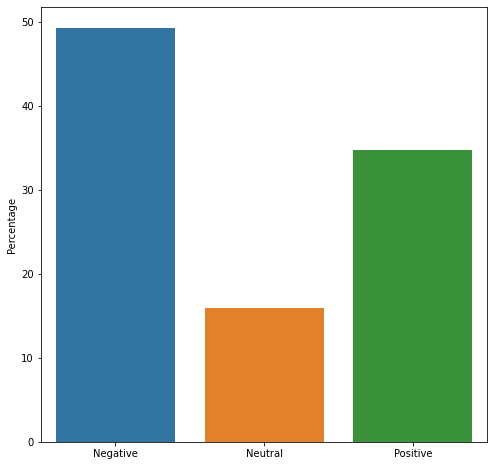

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 8))
counts = headlines_polarity.label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.show()

<b>Insights:</b> It is clear from the above bar chart that the distribution of news is quite even when it comes to the polarity of the news. Both Positive and negative sentiment accounted for about 40% each despite the time frame in which the newss articles were collected. At the prima facie level, this goes on to show that the media outlets are not biased towards the negative news.

In [125]:
headlines_polarity['compound'].iplot(
    kind='hist',
    bins=30,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

<b>Insights:</b> The graph above shows the univariate polarity distribution of the news article headlines and it can be seen that the polarity score of the headlines is quite equally distributed across the range of 1 to -1. We have equal number of records on both sides of 0. Thus now we can reach a conclusion that though we often feel that only the negative news make it to the headlines, that is certainly not the case. It is our brain that is susceptible to this negativity bias, wherein we forget the positive side of the story and focus only on the negative side of it.

Text(0.5, 0, ' Mean Polarity')

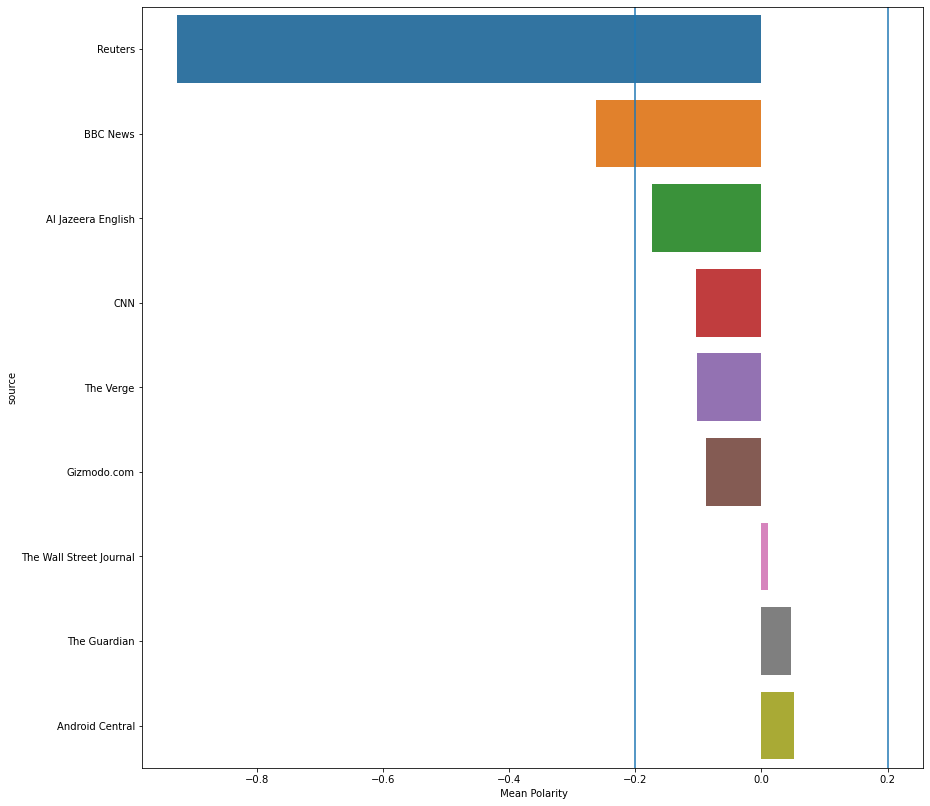

In [127]:
# Checking out the distribution of the news polarity based on the source of news
df_polarity = pd.read_csv(r'C:\Users\user\Datasets\news\news_polarity.csv')
df_polarity = df_polarity.sort_values(['compound']).reset_index(drop=True)
fig, ax = plt.subplots(figsize=(14, 14))
ax = sns.barplot(x='compound', y='source', data=df_polarity)
ax.set_xlabel(' Mean Polarity')
ax.axvline(0.2)
ax.axvline(-0.2)

<b>Insights:</b> The bar chart above shows mean polarity of some of the top news publishers from around the world.The two verical lines act a baseline to categorize whether the overall sentiment of the news is positive or negative. We can see that Bloomberg, Al Jazeera and BBC news have a negative mean polarity. which means these publishers genearally tend to cover stories that are negtive in its sentiments. Al jazeera mainly focuses on the war torn middle earth therfore, it is not surprising for it to have neagtive mean polarity. Bloomberg mainly covers the finance realted news or the news related to the stock market and one possible reason for it to have negative news polaity is Coronavirus Pandemic, which has had a profound impact on the financial market in the last one month. However, It is surprising to find BBC on top of that list We can also see that the news publishers like Techcrunch and lifehacker which often focus on tech news have a positive mean polarity

In [128]:
# Box Plot for the top news publishers
y0 = headlines_polarity.loc[headlines_polarity['source'] == 'Al Jazeera English']['compound']
y1 = headlines_polarity.loc[headlines_polarity['source'] == 'BBC News']['compound']
y2 = headlines_polarity.loc[headlines_polarity['source'] == 'The Wall Street Journal']['compound']
y3 = headlines_polarity.loc[headlines_polarity['source'] == 'The Washington Post']['compound']
y4 = headlines_polarity.loc[headlines_polarity['source'] == 'Economist.com']['compound']
y5 = headlines_polarity.loc[headlines_polarity['source'] == 'Hindustantimes.com']['compound']

trace0 = go.Box(
    y=y0,
    name = 'Al Jazeera',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'BBC',
    marker = dict(
        color = 'rgb(0, 150, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Wall Street Journal',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Washington Post',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Economist',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Hindustantimes',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of Popular News publishers"
)
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Popular News publishers")

<b>Insights:</b> The box plot above shows five number summary for the top news publishers. The five number summary, which includes the minimumm, Q1 (the first quartile, or the 25% mark), the median, Q3 (the third quartile, or the 75% mark), and the maximum gives us the detailed idea about the exact nature of news these sources publish.sometimes mean can be misleading as it is prone to extreame values or outliers and in such cases median gives us a better idea. Looking at the graph we can see that the all the publishers report news on both sides of the spectrum. i.e. positive and negative. The median for Al jazeera and BBC is significantly low which confirms without any doubt that these publishers tend to have negative outlook to their stories. The highly reputed, Washington Post stands by its high standards and has the median news polarity of exact 0. So does The Economist. Both of these news publishers also have highest interquartile range which goes on to show they cover both sides of the stories and are not biased.

In [129]:
y0 = headlines_polarity.loc[headlines_polarity['source'] == 'Al Jazeera English']['word_count']
y1 = headlines_polarity.loc[headlines_polarity['source'] == 'BBC News']['word_count']
y2 = headlines_polarity.loc[headlines_polarity['source'] == 'The Wall Street Journal']['word_count']
y3 = headlines_polarity.loc[headlines_polarity['source'] == 'The Washington Post']['word_count']
y4 = headlines_polarity.loc[headlines_polarity['source'] == 'Economist.com']['word_count']
y5 = headlines_polarity.loc[headlines_polarity['source'] == 'Hindustantimes.com']['word_count']

trace0 = go.Box(
    y=y0,
    name = 'Al Jazeera',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'BBC',
    marker = dict(
        color = 'rgb(0, 150, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Wall Street Journal',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'Washington Post',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Economist',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Hindustantimes',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Headline Length Boxplot of Popular News publishers"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Headline Length Boxplot of Popular News publishers")

<b>Insights: </b>The word count in the headline is often neglected but it is a critical aspect when it comes to engaging with the viewers. According to a research it was discovered that the sweet spot for headlines is 18–30 words. Anything above and below that saw reduced click-through rates. We see that most of the news sources seem follow the similar trend. The Economist is quite consistent with its headline length and has no outliers or extreame values. BBC on has the least variance in the headline length.

In [130]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
print(type(stop_words))
specific_words_list = ['char', 'u', 'hindustan', 'doj', 'washington'] 
#stop_words.extend(specific_words_list )
def process_text(headlines):
    tokens = []
    for line in headlines:
        line = line.lower()
        toks = tokenizer.tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)  
    return tokens

<class 'list'>


### Word Frequency Distribution and Zipf's law
Zipf law: Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. So word number n has a frequency proportional to 1/n. Thus the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, etc. For example, in one sample of words in the English language, the most frequently occurring word, 'the', accounts for nearly 7% of all the words (69,971 out of slightly over 1 million). True to Zipf's Law, the second-place word 'of' accounts for slightly over 3.5% of words (36,411 occurrences). (source: wikipedia)

So essentially what the law actually states is that:

1. The most appearing word in a corpus suppose has frequency f
2. The second most appearing word would have frequency roughly f/2
3. Then the third most appearing word would have frequency roughly f/3
4. Then the fourth most appearing word would have frequency roughly f/4 and so on.

What is astonishing is that this law holds true for almost all large natural language corpuses.For eg : Books, ancient scripts, even temperature trends over past years etc.

I decided upon coming across Zipf’s Law that I will investigate if the mysterious Zipf's law holds true for a news corpus collected from not one but as many as 39 differnt sources of news article.

In [131]:
# Positive headlines and its distribution 
pos_lines = list(headlines_polarity[headlines_polarity.label == 1].headline)
# extract the headlines that had label =1 which meant it had a positive overall sentiment
pos_tokens =process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

# Now negative headlines
neg_lines = list(headlines_polarity[headlines_polarity.label == -1].headline)
# extract the headlines that had label-1 which meant it had a negative overall sentiment
neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

Plotting the word distribution for positive sentiment words seperately and negative sentiment words seperately so that we can verify the law twice on the same corpus.

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Word Frequency Distribution (Positive)')

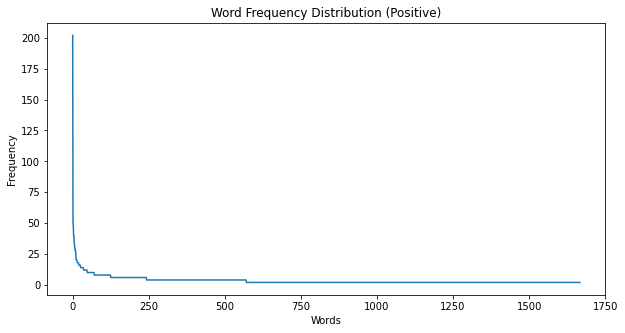

In [132]:
# plotting the word distribution for positive headlines
y_val = [x[1] for x in pos_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

Text(0.5, 0, 'Words')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Word Frequency Distribution (Negative)')

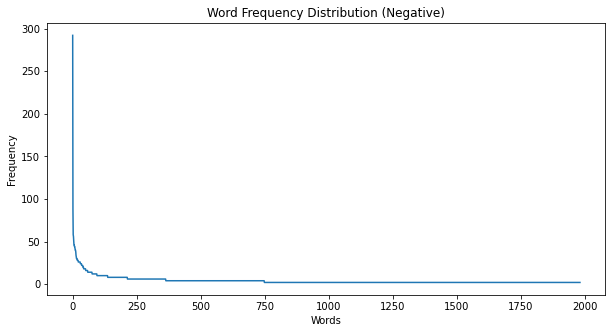

In [133]:
# Plotting the word frequency distribution for negative headlines
y_val = [x[1] for x in neg_freq.most_common()]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

<b>Insights:</b> It can be seen from the above two plots that the both the Positive sentiment words as well as the negative sentiment words follow the zipf's law. Now the how do we know whether it follws the zipfs's law? By observing the plot we see words close to zer have a very high word frequency and then it drops to an 'L' shaped curve. which is typical characteristic of a zipfian distribution. Furthermore, It can also be inferred that Zipf’s law follows the Pareto distribution where only first 20 % of words results into 80 % of frequency of entire corpus. It is important to mention that In all the results, there are some instances where the word frequency not always falls to 1/2 to its previous, which is fine because overall pattern approximates the nature.

## Wordcloud : To see whats dominating the news articles

<Figure size 1080x1080 with 0 Axes>

(-0.5, 1499.5, 1199.5, -0.5)

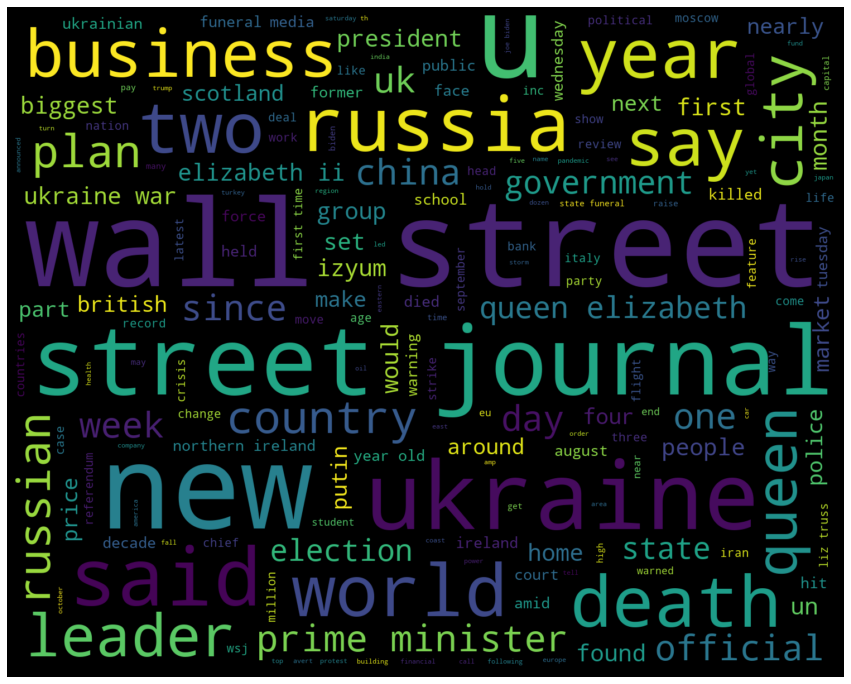

In [134]:
data=news_articles_df
stop = ["https", "co", "char","chars"] + list(stop_words)
wc = WordCloud(stopwords=stop, max_words=700, margin=10, background_color='black',
scale=3, relative_scaling = 0.4, width=500, height=400,
random_state=1).generate(' '.join(data['combined_text']))
plt.figure(figsize=(15,15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Insights:</b> The word cloud is a analysis technique wherein more commonly the term appears within the text being analysed, the larger the word appears in the image generated. The Word cloud image above shows which words dominated the content of the news during the period of feb 14 to march 29. It is no surprise here that the term Coronavirus appears the largest in the word cloud, highlighting the global scale of the this pandemic. some of the other words that appear frequently in the news is government which I believe is again related to Covid-19 and government's response to it. some of the other interesting observation here is the term first and new. it is not quite clear in what context these were used and we will perform bigram analysis to better understand the context of these words. US and India also appear to have appeaared significantly in the news, this is because of President Trump's India visit in february this year. Moreover most of the News agencies are based in the US and as a result of which the they cover a lot of stories involving the United States.

### Analyzing the distribution of words and Biagram Analysis

In [138]:
# news article specific stopwords were downloaded from:  https://github.com/vikasing/news-stopwords.git
# Then, I removed all the news specific stopwords  from my dataframe's column of token 
def remove_stopwords(params):
    with open(r'C:\Users\user\Datasets\news\stopwords1k.csv','r') as my_stopwords:
        stopwords_list = my_stopwords.read()
        new_list = []
        for param in params:
            if str(param) not in stopwords_list:
                new_list.append(param)
            else:
                pass # You can write something to do if the stopword is found
    my_stopwords.close()
    return (new_list)
new_list = remove_stopwords(news_articles_df['tokens'])

In [139]:
# A genralized function to fetch the top n words from the corpus 
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(news_articles_df['combined_text'], 20)

df1 = pd.DataFrame(common_words, columns = ['Text' , 'count'])

df1.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in the News article before removing stop words')

<b>Insights:</b> We can see that before removing the stop word, the top 20 most frequently occuring words in the corpus are the, to, of, in, etc which does not make much sense these are the words that do not convey any anything about the topic. Other thing to notice here is that again even here we do see the distribution following the zipf's law

In [140]:
common_words = get_top_n_words(new_list, 20)
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in News articles after removing stop words')

<b>Insights:</b> After removing the stopwords we see that after removing the news specific stopwords, now most of the words make a lot momre sense, even though there are still some stop words present like chars, one, two which do not make much sense but overall we that the stop word removal does a good job to give us an indication as to what dominated the news. Coronavirus as expected, occured 2778 times in the arounf 4000 news articles. other frequent words compliment the wordclound plot described earlier.

#### Bigram Analysis
Some English words occur together more frequently. For example - blue sky, do or die, best performance, heavy rain etc. So, in a text document. lets analyze which two words appeared most frequently in the news article corpus.

In [141]:
# A genralized function to extact the top n most frequently occuring bigram from the text corpus 
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(new_list, 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
df4.groupby('Text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in News Corpus after removing stop words')

wall street 112
street journal 104
queen elizabeth 32
prime minister 30
elizabeth ii 24
ukraine war 24
northern ireland 20
year old 18
liz truss 16
state funeral 14
death queen 14
joe biden 12
wsj wall 12
mortgage rates 12
million people 12
united nations 12
far right 12
white house 10
business wall 10
private equity 10


<b>Insights:</b> We can see that by looking at bigrams instead of just single words we are able to get a better sense of the what is trending in the news. We can see that the word new york bigram makes sense now as compared to earlier. Those two words individually do not make any sense but now looking at bigram we can notice that it is acttually referring to the New York City and it is probably in the news after it has now emerged as the new Coronavirus hotspot with close to 1000 deaths. We can also see the word social distancing which signifies the emphasis being given by the media on it.

In [143]:
# extracting the parts of specch from the news headlines using textBlob

nltk.download('averaged_perceptron_tagger')

blob = TextBlob(str(news_articles_df['title']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:5]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for News Headlines')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

1. NNP: Proper noun
2. CD : Cardinal digit
3. NN : Noun
4. IN : Preposition/subordinating conjunction
5. VB : Verb

<b>Insights:</b> We can see that the parts of speech used in the News article's heaadlines are dominated by the aforementioned parts of speech. We see proper nouns appearing a lot because news articles often talk about people and or place therfore it's not surprising to see proper noun at the first place. Cardinal digit was the second most appearing POS. The reason is that the Headlines are specific and give us the quantity for example: "900 People die In Italy in one single day". Including numbers in the headlines make them specific and increase its impact on the reader. Furthermore, Headlines are complete sentences and hence the presence of preposition and conjuctions. Lastly, the Headlines are full of action verbs since they have maximum imapct on the user.

## Conclusion

In summary, I have answered the initial questions through the means of analysis of the news articles. I have concluded that though we may feel as if the media is focussing too much on the negative side of the story, this is certainly not the case in reality. The Positive and the negative sentiments associated with over 4000 news articles clearly indicates that both sentiments are equally present in the news articles. Furthermore, I also found that there are some news publishers like Al Jazeera and BBC news that have a high median negative sentiment polarity. I was also able to figure out the Ideal length of the headleans from the trends observed. It seemed 18-30 words made up the headline in most news articles. All the subsequent analysis focussed on finding the major trends in the news and to analyse how the content of news articles and headlines.